In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import rank_bm25
import nltk
from nltk import stem
import tqdm 
from mlutil.parallel import mapp
from toolz import partial



plt.style.use('dark_background')

In [2]:
!pwd

/home/kuba/Projects/wikir_text_mining


In [3]:
!ls wikIR1k/training/

BM25.metrics.json  BM25.qrels.csv  BM25.res  qrels  queries.csv


In [4]:
!head wikIR1k/training/queries.csv

id_left,text_left
17783,apulia
6054,isaac newton
13635,u boat
30212,provinces of france
8663,mattel
18449,vandals
15010,the walt disney company
4863,george orwell
349,aol


In [5]:
!wc -l wikIR1k/training/BM25.metrics.json

0 wikIR1k/training/BM25.metrics.json


In [6]:
!head wikIR1k/training/BM25.metrics.json

{"P_5": 0.22164133738601574, "P_10": 0.17428571428571302, "P_20": 0.12799392097264375, "ndcg_cut_5": 0.26061449994418684, "ndcg_cut_10": 0.24561694742388185, "ndcg_cut_20": 0.2519854508215273, "ndcg_cut_100": 0.28861192661304225, "map": 0.1337089125785199, "recall_100": 0.32546280449193543}

In [7]:
!head wikIR1k/training/BM25.qrels.csv

,id_left,id_right,label
0,17783,77063,0
1,17783,17774,0
2,17783,17783,2
3,17783,20576,0
4,17783,77066,0
5,17783,35888,1
6,17783,77064,0
7,17783,97038,1
8,17783,29547,0


In [8]:
!head wikIR1k/training/qrels

17783	0	17783	2
17783	0	17784	1
17783	0	17846	1
17783	0	17994	1
17783	0	17997	1
17783	0	18747	1
17783	0	21972	1
17783	0	35888	1
17783	0	37702	1
17783	0	76737	1


## Documents

In [9]:
documents_df = pd.read_csv('wikIR1k/documents.csv', index_col='id_right')

In [10]:
documents_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99987 entries, 0 to 99999
Data columns (total 1 columns):
text_right    99987 non-null object
dtypes: object(1)
memory usage: 1.5+ MB


In [11]:
documents_df.head()

,text_right
id_right,
0,these institutions are often described as stat...
1,parents usually notice signs during the first ...
2,a planet like earth it is dimensionless and me...
3,it is similar to the ancient greek letter alph...
4,it is bordered by tennessee to the north georg...


In [12]:
document_lengths = documents_df['text_right'].apply(lambda s: s.count(' '))

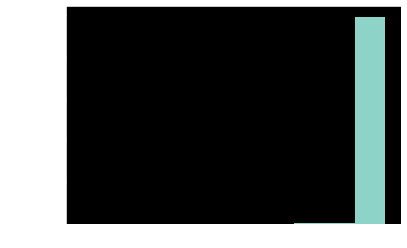

In [13]:
document_lengths.plot.hist();

## Queries

In [14]:
queries_df = pd.read_csv('wikIR1k/training/queries.csv', index_col='id_left')

In [15]:
queries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1645 entries, 17783 to 12052
Data columns (total 1 columns):
text_left    1645 non-null object
dtypes: object(1)
memory usage: 25.7+ KB


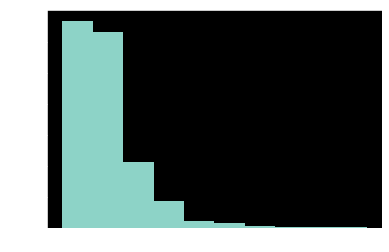

In [16]:
queries_df['text_left'].apply(lambda s: len(s.split())).plot.hist();

# BM25 results

In [17]:
!head wikIR1k/training/BM25.qrels.csv

,id_left,id_right,label
0,17783,77063,0
1,17783,17774,0
2,17783,17783,2
3,17783,20576,0
4,17783,77066,0
5,17783,35888,1
6,17783,77064,0
7,17783,97038,1
8,17783,29547,0


In [34]:
relevances = pd.read_csv('wikIR1k/training/BM25.qrels.csv')
relevant_pairs=relevances[relevances['label'] != 0]
relevant_pairs.shape

(8588, 4)

In [41]:
relevant_pairs.merge(queries_df, on='id_left').merge(documents_df, on='id_right')

,Unnamed: 0,id_left,id_right,label,text_left,text_right
0,2,17783,17783,2,apulia,the region comprises and its population is abo...
1,5,17783,35888,1,apulia,it also has two coastlines a 30 km stretch on ...
2,21902,17774,35888,1,calabria,it also has two coastlines a 30 km stretch on ...
3,37971,95944,35888,1,regions of italy,it also has two coastlines a 30 km stretch on ...
4,74818,17843,35888,1,campania,it also has two coastlines a 30 km stretch on ...
...,...,...,...,...,...,...
8583,164400,12052,29167,1,sonic youth,after graduating from los angeles s otis colle...
8584,164401,12052,88503,1,sonic youth,the band recorded the album between july and a...
8585,164403,12052,12052,2,sonic youth,founding members thurston moore guitar vocals ...
8586,164404,12052,29166,1,sonic youth,he has also participated in many solo and grou...


In [18]:
import rank_bm25

In [21]:
stop_words = set(nltk.corpus.stopwords.words('english'))


def get_document_stems(doc_with_key, stemmer):
    key, value = doc_with_key
    value = value['text_right']
    stems = [stemmer.stem(elem) for elem in value.split(" ") if elem not in stop_words]
    return key, stems 


def make_bm25(documents, stemmer=stem.PorterStemmer()):
    docs_dict = dict(mapp(partial(get_document_stems, stemmer=stemmer), documents.iterrows()))
    return rank_bm25.BM25Okapi(docs_dict.values())

/etc/miniconda/envs/ml/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)
W0110 21:46:50.178014 139707246880576 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [22]:
%%time
bm25 = make_bm25(documents_df)

CPU times: user 52.4 s, sys: 4.47 s, total: 56.8 s
Wall time: 1min 4s


In [276]:
import pytrec_eval

qrels_all = pd.read_csv('wikIR1k/training/BM25.qrels.csv', index_col=0)
qrels = qrels_all[qrels_all['label'] != 0]

qrels_trec = qrels.groupby('id_left')['id_right'].apply(list)
qrels_trec

id_left
4        [13565, 39189, 4, 38981, 39019, 38863, 38972, ...
6                                                  [20527]
9                      [86246, 24141, 24157, 85150, 24248]
22                                  [22, 572, 88364, 7955]
24                  [24, 29460, 7767, 29525, 29524, 29531]
                               ...                        
98402                                [98402, 64632, 62430]
98706                                              [50628]
98896                                       [90224, 87052]
99191                                [99191, 99192, 83289]
99815                         [99815, 77977, 80197, 85908]
Name: id_right, Length: 1240, dtype: object

In [299]:
n_tmp = 100

In [300]:
qrels_trec_tmp = qrels_trec[:n_tmp].to_dict()
#qrels_trec.to_dict()

In [301]:
qrels_trec_tmp = {
    str(k): {str(v): 1 for v in vals}
    for (k, vals) in qrels_trec_tmp.items()
}

In [302]:
qrels_trec_tmp

{'4': {'13565': 1,
  '39189': 1,
  '4': 1,
  '38981': 1,
  '39019': 1,
  '38863': 1,
  '38972': 1,
  '38832': 1,
  '39045': 1,
  '37423': 1,
  '38887': 1,
  '38781': 1,
  '38975': 1,
  '38749': 1,
  '38984': 1,
  '39173': 1,
  '38612': 1,
  '38905': 1,
  '15835': 1,
  '39121': 1,
  '38710': 1,
  '38879': 1,
  '38810': 1},
 '6': {'20527': 1},
 '9': {'86246': 1, '24141': 1, '24157': 1, '85150': 1, '24248': 1},
 '22': {'22': 1, '572': 1, '88364': 1, '7955': 1},
 '24': {'24': 1, '29460': 1, '7767': 1, '29525': 1, '29524': 1, '29531': 1},
 '28': {'22176': 1,
  '28': 1,
  '26069': 1,
  '15836': 1,
  '23160': 1,
  '26591': 1,
  '26068': 1},
 '33': {'39384': 1,
  '88302': 1,
  '32460': 1,
  '39336': 1,
  '39285': 1,
  '39521': 1,
  '95626': 1,
  '39377': 1,
  '3824': 1,
  '39387': 1,
  '27938': 1,
  '30495': 1,
  '32006': 1,
  '96062': 1,
  '1041': 1,
  '39422': 1,
  '39359': 1,
  '39503': 1,
  '39354': 1,
  '39416': 1,
  '39421': 1,
  '39455': 1,
  '39424': 1,
  '39410': 1,
  '39222': 1,
  '3

In [303]:
evaluator = pytrec_eval.RelevanceEvaluator(
    qrels_trec_tmp,  {"map","ndcg_cut","recall","P"} 
)



In [304]:
bm25_relevant_indices = []
queries_loc = list(map(int, qrels_trec_tmp.keys()))
for __, q in tqdm.tqdm(queries_df.loc[queries_loc].iterrows()):
    query = [nltk.stem.PorterStemmer().stem(t) for t in q['text_left'].split()]
    sorted_indices = np.argsort(-bm25.get_scores(query))[:100]
    bm25_relevant_indices.append(sorted_indices)

100it [00:05, 19.08it/s]


In [305]:
bm25_relevant_indices[:5]

[array([13560,   376, 22775, 66521,     4, 28911, 71924, 31453, 39181,
        38870, 38608, 39011, 22514, 80771, 30084, 38973, 30080, 38434,
        77252, 28914, 30263,   294, 28917, 71330, 39104, 38964, 38784,
        28924, 28927,  5896, 34254, 61424, 29224, 38855, 30252, 38824,
        38972, 30076, 38975, 42511, 39128, 32425, 30090, 38604, 38944,
        38741, 98630, 30248, 38773, 57867, 38974, 37842, 29028,   776,
        88326, 28932, 74556, 34142, 28910, 39037, 39165, 38976, 72988,
        29221, 29038, 38709, 34010, 22338, 30250, 33700, 38897, 75401,
        39843, 29029, 38802, 38861, 29034, 30078, 29225, 38831, 81104,
        38871, 37839, 43156, 38967, 38606, 38971, 72981, 39206, 28922,
        15830, 38702, 28913, 38701, 34818, 38879, 39113, 29204, 74647,
        38326]),
 array([89882, 44720, 78092, 20521, 47914, 24498, 99694, 62113, 65054,
        67835, 45817, 22906, 33929, 36011, 34675, 61849, 47753,  6868,
        33165, 36189, 33128, 78017, 44880, 44134, 16185, 361

In [306]:
run = {
    str(i): {
        str(idx): (100 - j) / 100
        for idxs in bm25_relevant_indices
        for (j, idx) in enumerate(idxs) 
    }
    for i in queries_loc 
}

In [307]:
run

{'4': {'13560': 1.0,
  '376': 0.99,
  '22775': 0.98,
  '66521': 0.97,
  '4': 0.96,
  '28911': 0.95,
  '71924': 0.94,
  '31453': 0.93,
  '39181': 0.92,
  '38870': 0.91,
  '38608': 0.9,
  '39011': 0.42,
  '22514': 0.88,
  '80771': 0.53,
  '30084': 0.86,
  '38973': 0.85,
  '30080': 0.84,
  '38434': 0.83,
  '77252': 0.82,
  '28914': 0.81,
  '30263': 0.8,
  '294': 0.79,
  '28917': 0.78,
  '71330': 0.77,
  '39104': 0.76,
  '38964': 0.75,
  '38784': 0.74,
  '28924': 0.73,
  '28927': 0.72,
  '5896': 0.71,
  '34254': 0.7,
  '61424': 0.69,
  '29224': 0.68,
  '38855': 0.67,
  '30252': 0.66,
  '38824': 0.65,
  '38972': 0.64,
  '30076': 0.63,
  '38975': 0.62,
  '42511': 0.61,
  '39128': 0.6,
  '32425': 0.59,
  '30090': 0.58,
  '38604': 0.57,
  '38944': 0.56,
  '38741': 0.55,
  '98630': 0.54,
  '30248': 0.53,
  '38773': 0.52,
  '57867': 0.51,
  '38974': 0.5,
  '37842': 0.49,
  '29028': 0.48,
  '776': 0.47,
  '88326': 0.46,
  '28932': 0.45,
  '74556': 0.44,
  '34142': 0.43,
  '28910': 0.42,
  '39037'

In [308]:
import json

evaluator.evaluate(run)

{'4': {'map': 0.00020470432759403767,
  'P_5': 0.0,
  'P_10': 0.0,
  'P_15': 0.0,
  'P_20': 0.0,
  'P_30': 0.0,
  'P_100': 0.0,
  'P_200': 0.0,
  'P_500': 0.002,
  'P_1000': 0.001,
  'recall_5': 0.0,
  'recall_10': 0.0,
  'recall_15': 0.0,
  'recall_20': 0.0,
  'recall_30': 0.0,
  'recall_100': 0.0,
  'recall_200': 0.0,
  'recall_500': 0.043478260869565216,
  'recall_1000': 0.043478260869565216,
  'ndcg_cut_5': 0.0,
  'ndcg_cut_10': 0.0,
  'ndcg_cut_15': 0.0,
  'ndcg_cut_20': 0.0,
  'ndcg_cut_30': 0.0,
  'ndcg_cut_100': 0.0,
  'ndcg_cut_200': 0.0,
  'ndcg_cut_500': 0.01510721211281321,
  'ndcg_cut_1000': 0.01510721211281321},
 '6': {'map': 0.0,
  'P_5': 0.0,
  'P_10': 0.0,
  'P_15': 0.0,
  'P_20': 0.0,
  'P_30': 0.0,
  'P_100': 0.0,
  'P_200': 0.0,
  'P_500': 0.0,
  'P_1000': 0.0,
  'recall_5': 0.0,
  'recall_10': 0.0,
  'recall_15': 0.0,
  'recall_20': 0.0,
  'recall_30': 0.0,
  'recall_100': 0.0,
  'recall_200': 0.0,
  'recall_500': 0.0,
  'recall_1000': 0.0,
  'ndcg_cut_5': 0.0,
  '

In [309]:
results_df = pd.DataFrame.from_records(evaluator.evaluate(run)).T

In [310]:
results_df.mean()

map              0.002971
P_5              0.002000
P_10             0.001000
P_15             0.000667
P_20             0.001500
P_30             0.001667
P_100            0.003100
P_200            0.002100
P_500            0.001500
P_1000           0.001000
recall_5         0.003333
recall_10        0.003333
recall_15        0.003333
recall_20        0.016667
recall_30        0.019004
recall_100       0.074195
recall_200       0.093072
recall_500       0.150720
recall_1000      0.191042
ndcg_cut_5       0.001815
ndcg_cut_10      0.001815
ndcg_cut_15      0.001815
ndcg_cut_20      0.005234
ndcg_cut_30      0.006221
ndcg_cut_100     0.020887
ndcg_cut_200     0.025419
ndcg_cut_500     0.036558
ndcg_cut_1000    0.043771
dtype: float64

In [311]:
results_df

,map,P_5,P_10,P_15,P_20,P_30,P_100,P_200,P_500,P_1000,...,recall_1000,ndcg_cut_5,ndcg_cut_10,ndcg_cut_15,ndcg_cut_20,ndcg_cut_30,ndcg_cut_100,ndcg_cut_200,ndcg_cut_500,ndcg_cut_1000
1037,0.000216,0.0,0.0,0.000000,0.00,0.000000,0.00,0.000,0.000,0.001,...,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031552
1061,0.001506,0.0,0.0,0.000000,0.00,0.000000,0.01,0.005,0.002,0.001,...,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.039570,0.039570,0.039570,0.039570
1070,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.00,0.000,0.000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
110,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.00,0.000,0.000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1109,0.001432,0.0,0.0,0.000000,0.00,0.000000,0.00,0.005,0.002,0.001,...,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046042,0.046042,0.046042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,0.000045,0.0,0.0,0.000000,0.00,0.000000,0.00,0.000,0.000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
91,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.00,0.000,0.000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
951,0.001692,0.0,0.0,0.000000,0.00,0.000000,0.01,0.005,0.002,0.001,...,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.042136,0.042136,0.042136,0.042136
956,0.066667,0.2,0.1,0.066667,0.05,0.033333,0.01,0.005,0.002,0.001,...,0.333333,0.181542,0.181542,0.181542,0.181542,0.181542,0.181542,0.181542,0.181542,0.181542
